In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Softmax
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [4]:
words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r',encoding='utf-8') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'data/glove.6B.50d.txt')

In [ ]:
import nltk

In [17]:
from nltk.corpus import wordnet

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHRIVED\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\SHRIVED\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [9]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

In [18]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def post_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

def message_to_token_list(s):
  #tokenization
  tokens = tokenizer.tokenize(s)
  #lowercasing
  lowercased_tokens = [t.lower() for t in tokens]
  #postagging
  pos_tagged = nltk.pos_tag(lowercased_tokens)
  words_tagged = [(word[0], post_tagger(word[1])) for word in pos_tagged]
  #lemmatization
  lemmatized_tokens = []
  for w, t in words_tagged:
    if t is None:
      lemmatized_tokens.append(w)
    else:
      lemmatized_tokens.append(lemmatizer.lemmatize(w, t))
  useful_tokens = [t for t in lemmatized_tokens if t in words]

  return useful_tokens

In [19]:
def message_to_word_vectors(message, word_dict=words):
  processed_list_of_tokens = message_to_token_list(message)

  vectors = []

  for token in processed_list_of_tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)

In [20]:
df = df.sample(frac=1, random_state=1)
df.reset_index(drop=True, inplace=True)

split_index_1 = int(len(df) * 0.7)
split_index_2 = int(len(df) * 0.85)

df, val_df, test_df = df[:split_index_1], df[split_index_1:split_index_2], df[split_index_2:]

len(df), len(val_df), len(test_df)

(15661, 3356, 3356)

In [21]:
def df_to_X_y(dff):
  y = dff['label'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for message in dff['tweet']:
    message_as_vector_seq = message_to_word_vectors(message)
    
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y

In [22]:
X_train, y_train = df_to_X_y(df)

print(len(X_train), len(X_train[0]))

15661 9


(array([2.429e+03, 4.910e+03, 3.996e+03, 3.036e+03, 1.099e+03, 1.810e+02,
        7.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([ 1. ,  6.2, 11.4, 16.6, 21.8, 27. , 32.2, 37.4, 42.6, 47.8, 53. ]),
 <BarContainer object of 10 artists>)

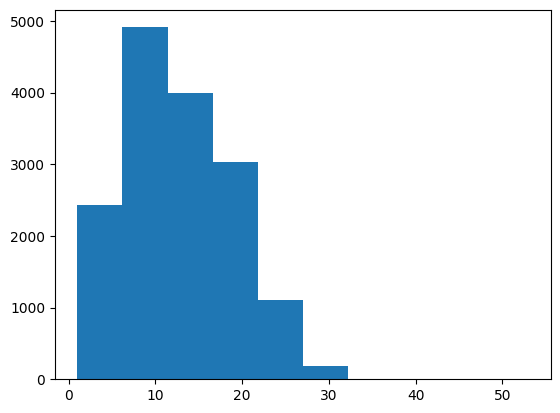

In [23]:
sequence_lengths = []

for i in range(len(X_train)):
  sequence_lengths.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths)

In [24]:
pd.Series(sequence_lengths).describe()

count    15661.000000
mean        12.704872
std          5.925538
min          1.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         53.000000
dtype: float64

In [25]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=57):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

In [26]:
X_train_pad = pad_X(X_train)
X_train_pad.shape, y_train.shape

((15661, 57, 50), (15661,))

In [27]:
X_val,y_val = df_to_X_y(val_df)
X_val_pad = pad_X(X_val)
X_val_pad.shape, y_val.shape

((3356, 57, 50), (3356,))

In [28]:
X_test, y_test = df_to_X_y(test_df)
X_test_pad = pad_X(X_test)
X_test_pad.shape, y_test.shape

((3356, 57, 50), (3356,))

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [30]:
model = Sequential([])

model.add(layers.Input(shape=(57,50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 57, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 57, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 57, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 57, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3648)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         3,649 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,137 (387.25 KB)

 Trainable params: 99,137 (387.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model.keras', save_best_only=True)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy', AUC(name='auc')])

In [33]:
freq = pd.value_counts(df['label'])
freq

C:\Users\SHRIVED\AppData\Local\Temp\ipykernel_42972\2317570362.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq = pd.value_counts(df['label'])


label
0    14578
1     1083
Name: count, dtype: int64

In [34]:
weights = {0:freq.sum()/freq[0], 1:freq.sum()/freq[1]}
weights

{0: 1.074290026066676, 1: 14.460757156048015}

In [39]:
model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=32, batch_size=50, callbacks=[cp], class_weight=weights)

Epoch 1/32
314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.8515 - auc: 0.9378 - loss: 0.6147 - val_accuracy: 0.8567 - val_auc: 0.9060 - val_loss: 0.3218
Epoch 2/32
314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8632 - auc: 0.9493 - loss: 0.5738 - val_accuracy: 0.8558 - val_auc: 0.9073 - val_loss: 0.3245
Epoch 3/32
314/314 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8605 - auc: 0.9445 - loss: 0.5987 - val_accuracy: 0.8778 - val_auc: 0.9060 - val_loss: 0.2924
Epoch 4/32
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.8746 - auc: 0.9553 - loss: 0.5197 - val_accuracy: 0.8966 - val_auc: 0.9060 - val_loss: 0.2496
Epoch 5/32
314/314 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.8747 - auc: 0.9538 - loss: 0.5424 - val_accuracy: 0.8561 - val_auc: 0.9110 - val_loss: 0.3185
Epoch 6/32
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8690 - auc: 0.9545 - loss: 0.5364 - val_accuracy: 0.8546 - val_auc: 0.9085 - val_loss: 0.3135
Epoch 7/32
314/314 ━━━━━━━━━

In [40]:
from tensorflow.keras.models import load_model

best_model = load_model('model.keras')

In [41]:
test_pred = (best_model.predict(X_test_pad) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3121
           1       0.51      0.70      0.59       235

    accuracy                           0.93      3356
   macro avg       0.74      0.82      0.78      3356
weighted avg       0.94      0.93      0.94      3356

